In [212]:
import boto3
import botocore
import json
import s3fs
import ast
import pandas as pd
from pandas.io.json import json_normalize
from sagemaker import get_execution_role
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from scipy.sparse import csr_matrix

In [2]:
role = 'AWSGlueServiceSageMakerNotebookRole-Default'

## Games Users Have Played

In [3]:
with open('users_items.json') as f:
    lines = f.read().splitlines()

In [4]:
lst = [ast.literal_eval(line) for line in lines]

In [5]:
users_items = pd.DataFrame(lst)

In [6]:
users_items.head()

,user_id,items_count,steam_id,user_url,items
0,76561197970982479,277,76561197970982479,http://steamcommunity.com/profiles/76561197970...,"[{'item_id': '10', 'item_name': 'Counter-Strik..."
1,js41637,888,76561198035864385,http://steamcommunity.com/id/js41637,"[{'item_id': '10', 'item_name': 'Counter-Strik..."
2,evcentric,137,76561198007712555,http://steamcommunity.com/id/evcentric,"[{'item_id': '1200', 'item_name': 'Red Orchest..."
3,Riot-Punch,328,76561197963445855,http://steamcommunity.com/id/Riot-Punch,"[{'item_id': '10', 'item_name': 'Counter-Strik..."
4,doctr,541,76561198002099482,http://steamcommunity.com/id/doctr,"[{'item_id': '300', 'item_name': 'Day of Defea..."


#### Amount of Users

In [7]:
users_items.shape

(88310, 5)

In [8]:
users_items.user_id.nunique()

87626

#### Drop Duplicate Users

In [9]:
users_items.drop_duplicates(subset ="user_id", 
                     keep = 'first', inplace = True) 

In [10]:
users_items_lst = users_items.to_dict('records')

#### Explode Items Column to Get Playing Time

In [11]:
item_ratings = pd.json_normalize(data= users_items_lst, record_path = 'items', meta = ['user_id'])

In [12]:
item_ratings.head()

,item_id,item_name,playtime_forever,playtime_2weeks,user_id
0,10,Counter-Strike,6,0,76561197970982479
1,20,Team Fortress Classic,0,0,76561197970982479
2,30,Day of Defeat,7,0,76561197970982479
3,40,Deathmatch Classic,0,0,76561197970982479
4,50,Half-Life: Opposing Force,0,0,76561197970982479


In [13]:
item_ratings.shape

(5094082, 5)

In [14]:
item_ratings.dtypes

item_id             object
item_name           object
playtime_forever     int64
playtime_2weeks      int64
user_id             object
dtype: object

In [15]:
item_ratings.item_id = item_ratings.item_id.astype('int64')

#### Item Names

In [16]:
item_id = item_ratings.item_id.unique()

In [17]:
item_name = item_ratings.item_name.unique()

In [18]:
names = dict(zip(item_id,item_name))

#### EDA

In [19]:
ratings_mat = item_ratings.pivot_table(values = 'playtime_forever',index = 'user_id',columns = 'item_id')

In [20]:
ratings_mat.head()

item_id,10,20,30,40,50,60,70,80,100,130,...,527520,527570,527810,527890,527900,528580,528660,529670,529820,530720
user_id,,,,,,,,,,,,,,,,,,,,,
--000--,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
--ace--,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
--ionex--,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-2SV-vuLB-Kg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-404PageNotFound-,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


##### Density

In [21]:
num_ratings = item_ratings.shape[0]
user_count, item_count = ratings_mat.shape
density = num_ratings/(user_count*item_count)
print(density)

0.0065436938243076245


In [22]:
ratings_per_game = item_ratings.groupby('item_id')['playtime_forever'].count()
ratings_per_user = item_ratings.groupby('user_id')['playtime_forever'].count()

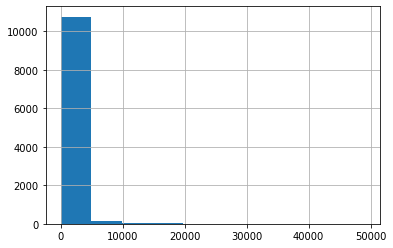

In [23]:
ratings_per_game.hist(bins = 10)

In [24]:
ratings_per_game.min()

1

In [25]:
ratings_per_game.max()

49136

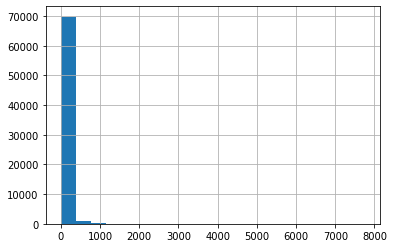

In [213]:
ratings_per_user.hist(bins = 20)

In [214]:
ratings_per_user.min()

1

In [215]:
ratings_per_user.max()

7762

#### Increase Density by Filtering Out Games and Users

In [216]:
test= pd.DataFrame(ratings_per_user)

In [217]:
test.shape

(70912, 1)

#### Users Who played 10 or more games

In [218]:
test = test[test.playtime_forever>=10]

In [219]:
test.shape

(57333, 1)

In [220]:
test2 = pd.DataFrame(ratings_per_game)

In [221]:
test2.shape

(10978, 1)

In [222]:
test2.head()

,playtime_forever
item_id,
10,9611
20,6268
30,3431
40,3242
50,6216


#### Games that were played by 5000 or more Users

In [223]:
test2=test2[test2.playtime_forever>=5000]

In [224]:
test2.shape

(210, 1)

In [225]:
item_ratings_test = item_ratings.loc[item_ratings.user_id.isin(test.index)]

In [226]:
item_ratings_test.shape

(5038365, 5)

In [227]:
item_ratings_test.user_id.nunique()

57333

In [228]:
item_ratings_test = item_ratings.loc[item_ratings.item_id.isin(test2.index)]

In [229]:
item_ratings_test.shape

(2175538, 5)

In [230]:
ratings_mat = item_ratings_test.pivot_table(values = 'playtime_forever',index = 'user_id',columns = 'item_id')

In [231]:
ratings_mat.shape

(70331, 210)

#### Users that played 30 or more games

In [177]:
ratings_mat = ratings_mat[(ratings_mat>0).sum(axis = 1)>=30]

In [178]:
ratings_mat.shape

(20540, 210)

In [179]:
num_ratings = ratings_mat.count().sum()
user_count, item_count = ratings_mat.shape
density = num_ratings/(user_count*item_count)
print(density)

0.3074187415959568


In [180]:
ratings_mat.head()

item_id,10,20,50,70,80,100,130,220,240,320,...,346900,363970,367540,377160,386360,407530,409710,409720,433850,439700
user_id,,,,,,,,,,,,,,,,,,,,,
-404PageNotFound-,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3963.0,NaN,...,0.0,NaN,NaN,NaN,7189.0,0.0,0.0,0.0,NaN,NaN
-AnimeIsMyThing-,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6119.0,NaN,...,NaN,4151.0,0.0,NaN,21446.0,0.0,NaN,NaN,2237.0,0.0
-Azsael-,NaN,NaN,NaN,NaN,NaN,NaN,NaN,605.0,NaN,0.0,...,NaN,NaN,NaN,13291.0,NaN,NaN,0.0,NaN,NaN,NaN
-GM-Dragon,14.0,0.0,0.0,133.0,NaN,NaN,0.0,NaN,NaN,0.0,...,NaN,NaN,NaN,1901.0,NaN,543.0,NaN,NaN,NaN,NaN
-Kenny,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,0.0


In [181]:
ratings_mat.shape

(20540, 210)

In [182]:
sim_mat = cosine_similarity(ratings_mat.fillna(0).T)

In [183]:
sim_mat = pd.DataFrame(sim_mat, index =ratings_mat.columns)

In [184]:
sim_mat.columns = ratings_mat.columns


In [185]:
sim_mat.head()

item_id,10,20,50,70,80,100,130,220,240,320,...,346900,363970,367540,377160,386360,407530,409710,409720,433850,439700
item_id,,,,,,,,,,,,,,,,,,,,,
10,1.000000,0.259294,0.128446,0.127675,0.144071,0.078595,0.128233,0.035792,0.092439,0.009678,...,0.029831,0.010757,0.000085,0.009942,0.002420,0.001069,0.001813,0.003921,0.023616,0.001700
20,0.259294,1.000000,0.517740,0.450637,0.007516,0.026155,0.521884,0.031906,0.081893,0.008747,...,0.067456,0.002357,0.000157,0.007805,0.000396,0.000063,0.001322,0.000584,0.000315,0.000314
50,0.128446,0.517740,1.000000,0.810774,0.015669,0.041543,0.965242,0.125790,0.013945,0.023579,...,0.020260,0.008500,0.001261,0.025075,0.001555,0.002778,0.005339,0.001928,0.000435,0.000273
70,0.127675,0.450637,0.810774,1.000000,0.025762,0.084885,0.802353,0.213581,0.038741,0.028483,...,0.077779,0.021724,0.006766,0.055965,0.006298,0.007829,0.016117,0.002942,0.003555,0.000922
80,0.144071,0.007516,0.015669,0.025762,1.000000,0.251836,0.006502,0.041523,0.051944,0.012479,...,0.021061,0.004991,0.001004,0.014996,0.002166,0.001137,0.001301,0.000360,0.005616,0.000120


In [186]:
sim_mat.shape

(210, 210)

In [187]:
def predict(user_id,sim_mat, ratings_mat, neighbors):
    
    sorted_sim_idx = np.argsort(np.array(test_sim_mat))
    nbh = sorted_sim_idx[:, -neighbors:]
    items_rated = np.array(ratings_mat.iloc[user_id].fillna(0)).nonzero()
    pred = np.zeros(test_sim_mat.shape[0])                                                         
    
    for item_to_rate in range(sim_mat.shape[0]):
        
        relevant_items = np.intersect1d(nbh[item_to_rate], items_rated, assume_unique =True)
        pred[item_to_rate] = ((sim_mat.iloc[item_to_rate,relevant_items].values*\
                               ratings_mat.iloc[user_id,relevant_items].values).sum())\
                                /(sim_mat.iloc[item_to_rate,relevant_items].sum())
    
    preds= np.nan_to_num(pred)
    return preds                                                         
                                                              

#### Train Test Split

In [188]:
def train_test(ratings_mat):
    train = ratings_mat.copy()
    test = []
    for i in range(train.shape[0]):
        # filter rated games
        ratings = np.array(train.iloc[i].fillna(0)).nonzero()[0]
        #pick random 10 for testing
        idx = np.random.choice(ratings,size = 10, replace = False)
        #append values to test_set
        test.append(idx)
        # change value to nan 
        train.iloc[i,idx]=np.nan
    return train, test

In [189]:
train_ratings_mat = ratings_mat.copy()

In [190]:
train_ratings_mat.shape

(20540, 210)

In [191]:
train_ratings_mat.head()

item_id,10,20,50,70,80,100,130,220,240,320,...,346900,363970,367540,377160,386360,407530,409710,409720,433850,439700
user_id,,,,,,,,,,,,,,,,,,,,,
-404PageNotFound-,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3963.0,NaN,...,0.0,NaN,NaN,NaN,7189.0,0.0,0.0,0.0,NaN,NaN
-AnimeIsMyThing-,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6119.0,NaN,...,NaN,4151.0,0.0,NaN,21446.0,0.0,NaN,NaN,2237.0,0.0
-Azsael-,NaN,NaN,NaN,NaN,NaN,NaN,NaN,605.0,NaN,0.0,...,NaN,NaN,NaN,13291.0,NaN,NaN,0.0,NaN,NaN,NaN
-GM-Dragon,14.0,0.0,0.0,133.0,NaN,NaN,0.0,NaN,NaN,0.0,...,NaN,NaN,NaN,1901.0,NaN,543.0,NaN,NaN,NaN,NaN
-Kenny,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,0.0


In [192]:
train_sim_mat = cosine_similarity(train_ratings_mat.fillna(0).T)

In [193]:
train_sim_mat = pd.DataFrame(train_sim_mat, index =train_ratings_mat.columns)
train_sim_mat.columns = train_ratings_mat.columns

In [194]:
train,test = train_test(train_ratings_mat)

In [197]:
train.to_csv('train.csv')

In [200]:
np.savetxt('test.csv', test, delimiter=',')

In [237]:
train.head()

item_id,10,20,50,70,80,100,130,220,240,320,...,346900,363970,367540,377160,386360,407530,409710,409720,433850,439700
user_id,,,,,,,,,,,,,,,,,,,,,
-404PageNotFound-,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,NaN,NaN,NaN,7189.0,0.0,0.0,0.0,NaN,NaN
-AnimeIsMyThing-,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.0,NaN,21446.0,0.0,NaN,NaN,2237.0,0.0
-Azsael-,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,...,NaN,NaN,NaN,13291.0,NaN,NaN,0.0,NaN,NaN,NaN
-GM-Dragon,14.0,0.0,0.0,133.0,NaN,NaN,0.0,NaN,NaN,0.0,...,NaN,NaN,NaN,1901.0,NaN,NaN,NaN,NaN,NaN,NaN
-Kenny,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,0.0


#### Evaluation

#### Predict Ratings

In [210]:
def predict(user_id,sim_mat, ratings_mat, neighbors):
    
    sorted_sim_idx = np.argsort(np.array(sim_mat))
    nbh = sorted_sim_idx[:, -neighbors:]
    items_rated = np.array(ratings_mat.iloc[user_id].fillna(0)).nonzero()
    pred = np.zeros(sim_mat.shape[0])                                                         
    
    for item_to_rate in range(sim_mat.shape[0]):
        
        relevant_items = np.intersect1d(nbh[item_to_rate], items_rated, assume_unique =True)
        pred[item_to_rate] = ((sim_mat.iloc[item_to_rate,relevant_items].values*\
                               ratings_mat.iloc[user_id,relevant_items].values).sum())\
                                /(sim_mat.iloc[item_to_rate,relevant_items].sum())
    
    preds= np.nan_to_num(pred)
    return preds                  

In [264]:
def precision(actual, predicted, k):
    act_set = set(actual)
    pred_set = set(predicted[:k])
    result = len(act_set & pred_set) / float(k)
    return result

def recall(actual, predicted, k):
    act_set = set(actual)
    pred_set = set(predicted[:k])
    result = len(act_set & pred_set) / float(len(act_set))
    return result

def avg_precision(actual, predicted, k):
    p = [precision(actual[i], predicted[i].argsort()[::-1][:k],k) for i in range(len(actual))]
    avg = sum(p)/len(p)
    return avg

def avg_recall(actual,predicted,k):
    r = [recall(actual[i], predicted[i].argsort()[::-1][:k],k) for i in range(len(actual))]
    avg = sum(r)/len(r)
    return avg
        

In [238]:
train_ratings = [predict(user_id, train_sim_mat, train,20) for user_id in range(train_ratings_mat.shape[0])]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in double_scalars
  del sys.path[0]


In [239]:
len(train_ratings)

20540

In [260]:
len(test)

20540

In [247]:
test = pd.read_csv('test.csv',header = None)

In [256]:
test = test.to_numpy()

In [265]:
avg_precision(test,train_ratings,10)

0.042020447906528376

In [266]:
avg_recall(test,train_ratings,10)

0.042020447906528376

#### See How the Recommendations Compare to the Games User_0 Actually played

Recommendations

In [267]:
user_0_idx= train_ratings[0].argsort()[::-1][:10]

In [268]:
user_0_game_recommendations = train_ratings_mat.iloc[0,user_0_idx].index

In [269]:
user_0_game_recommendations 

Int64Index([4000, 273110, 100, 70, 12120, 240, 439700, 50, 223710, 80], dtype='int64', name='item_id')

In [270]:
user_0_game_recs = [names[i]for i in user_0_game_recommendations]
for i in range(len(user_0_game_recs)):
    print(user_0_game_recs[i])

Just Cause
Gang Beasts
Sid Meier's Civilization III: Complete
Half-Life
Trials 2: Second Edition
Counter-Strike: Source
MASSIVE CHALICE
Half-Life: Opposing Force
GRID 2
Counter-Strike: Condition Zero Deleted Scenes


In [282]:
games[games.id.isin(user_0_game_recommendations)]

,publisher,genres,app_name,title,url,release_date,tags,discount_price,reviews_url,specs,price,early_access,id,developer,sentiment,metascore


In [283]:
games[games.title.isin(user_0_game_recs)]

,publisher,genres,app_name,title,url,release_date,tags,discount_price,reviews_url,specs,price,early_access,id,developer,sentiment,metascore
28,Valve,[Action],Half-Life,Half-Life,http://store.steampowered.com/app/70/HalfLife/,1998-11-08,"[FPS, Classic, Action, Sci-fi, Singleplayer, S...",NaN,http://steamcommunity.com/app/70/reviews/?brow...,"[Single-player, Multi-player, Valve Anti-Cheat...",9.99,False,70,Valve,Overwhelmingly Positive,96
3771,Double Fine Productions,"[Indie, Strategy]",MASSIVE CHALICE,MASSIVE CHALICE,http://store.steampowered.com/app/246110/MASSI...,2015-06-01,"[Strategy, Turn-Based, Indie, Tactical, Turn-B...",NaN,http://steamcommunity.com/app/246110/reviews/?...,"[Single-player, Steam Achievements, Full contr...",19.99,False,246110,Double Fine Productions,Mostly Positive,73
13380,Double Fine Presents,"[Action, Adventure, Casual, Indie]",Gang Beasts,Gang Beasts,http://store.steampowered.com/app/285900/Gang_...,2017-12-12,"[Funny, Multiplayer, Fighting, Local Multiplay...",NaN,http://steamcommunity.com/app/285900/reviews/?...,"[Multi-player, Online Multi-Player, Local Mult...",19.99,False,285900,Boneloaf,Mostly Positive,NaN
30175,"Codemasters, Feral Interactive (Mac)","[Racing, Sports]",GRID 2,GRID 2,http://store.steampowered.com/app/44350/GRID_2/,2013-05-27,"[Racing, Sports, Multiplayer, Arcade, Driving,...",NaN,http://steamcommunity.com/app/44350/reviews/?b...,"[Single-player, Multi-player, Steam Achievemen...",29.99,False,44350,"Codemasters Racing,Feral Interactive (Mac)",Very Positive,80
31829,RedLynx Ltd.,"[Indie, Racing, Sports]",Trials 2: Second Edition,Trials 2: Second Edition,http://store.steampowered.com/app/16600/Trials...,2008-03-01,"[Racing, Indie, Sports]",NaN,http://steamcommunity.com/app/16600/reviews/?b...,"[Single-player, Multi-player, Steam Achievements]",9.99,False,16600,Redlynx,Very Positive,NA
31877,Square Enix,[Action],Just Cause,Just Cause,http://store.steampowered.com/app/6880/Just_Ca...,2006-09-22,"[Action, Open World, Shooter, Third Person, Si...",NaN,http://steamcommunity.com/app/6880/reviews/?br...,[Single-player],6.99,False,6880,Avalanche Studios,Mixed,75
32012,Valve,[Action],Counter-Strike: Source,Counter-Strike: Source,http://store.steampowered.com/app/240/CounterS...,2004-11-01,"[Action, FPS, Multiplayer, Shooter, Team-Based...",NaN,http://steamcommunity.com/app/240/reviews/?bro...,"[Multi-player, Cross-Platform Multiplayer, Ste...",19.99,False,240,Valve,Overwhelmingly Positive,88
32104,Valve,[Action],Half-Life: Opposing Force,Half-Life: Opposing Force,http://store.steampowered.com/app/50/HalfLife_...,1999-11-01,"[FPS, Action, Sci-fi, Singleplayer, Classic, S...",NaN,http://steamcommunity.com/app/50/reviews/?brow...,"[Single-player, Multi-player, Valve Anti-Cheat...",4.99,False,50,Gearbox Software,Very Positive,NaN


Games user_0 actually played

In [284]:
user_0_games_played = np.array(train_ratings_mat.iloc[0].fillna(0)).nonzero()

In [286]:
user_0_games_played

(array([  8,  16,  17,  18,  20,  23,  27,  28,  35,  36,  48,  51,  55,
         56,  63,  69,  74,  75,  76,  77,  78,  82,  90,  93,  95,  98,
        100, 102, 106, 107, 108, 110, 112, 114, 117, 119, 121, 126, 130,
        131, 132, 134, 139, 140, 142, 143, 148, 149, 150, 152, 153, 155,
        160, 163, 166, 170, 175, 184, 186, 187, 188, 189, 190, 191, 196,
        197, 199, 204]),)

In [287]:
user_0_games_played = train_ratings_mat.iloc[0,user_0_games_played[0]].index

In [288]:
user_0_games_played = [names[i] for i in user_0_games_played]
for game in user_0_games_played:
    print(game)

Counter-Strike: Source
Left 4 Dead 2 Beta
Magicka
Borderlands 2
Deus Ex: Invisible War
Just Cause
BioShock Remastered
Beat Hazard
Call of Duty: Modern Warfare 2 - Multiplayer
Dragon Age: Origins
Terraria
The Moon Sliver
Arma 2: Operation Arrowhead
Arma 2: Operation Arrowhead Beta (Obsolete)
NOT A HERO
Just Cause 2
Batman: Arkham City GOTY
Homefront
Loadout
Super Hexagon
Costume Quest
Zoo Park
Gratuitous Tank Battles
Mortal Kombat: Legacy
GunZ 2: The Second Duel
No More Room in Hell
FTL: Faster Than Light
Hotline Miami
Deadlight
Infestation: Survivor Stories Classic
Red Faction: Armageddon
Arx Fatalis
The Political Machine
Stealth Bastard Deluxe
Warhammer 40,000: Dawn of War – Winter Assault
Free to Play
Infinity Wars - Animated Trading Card Game
DmC Devil May Cry
War Thunder
Saints Row IV
Baldur's Gate: Enhanced Edition
Mirror's Edge
Counter-Strike Nexon: Zombies
Spintires
Sven Co-op
Creeper World 3: Arc Eternal
War Inc. Battlezone
Alien Rage - Unlimited
The Red Solstice
Heroes & Gener

In [289]:
games[games.title.isin(user_0_games_played)]

,publisher,genres,app_name,title,url,release_date,tags,discount_price,reviews_url,specs,price,early_access,id,developer,sentiment,metascore
69,Arkane Studios,[RPG],Arx Fatalis,Arx Fatalis,http://store.steampowered.com/app/1700/Arx_Fat...,2002-11-12,"[RPG, First-Person, Classic, Atmospheric, Fant...",NaN,http://steamcommunity.com/app/1700/reviews/?br...,[Single-player],4.99,False,1700,Arkane Studios,Very Positive,77
342,Electronic Arts,[RPG],Dragon Age: Origins,Dragon Age: Origins,http://store.steampowered.com/app/17450/Dragon...,2009-11-06,"[RPG, Fantasy, Story Rich, Multiple Endings, S...",NaN,http://steamcommunity.com/app/17450/reviews/?b...,[Single-player],19.99,False,17450,BioWare,Very Positive,91
395,Cold Beam Games,"[Action, Casual, Indie]",Beat Hazard,Beat Hazard,http://store.steampowered.com/app/49600/Beat_H...,2010-04-15,"[Music, Indie, Shoot 'Em Up, Action, Music-Bas...",NaN,http://steamcommunity.com/app/49600/reviews/?b...,"[Single-player, Multi-player, Co-op, Shared/Sp...",9.99,False,49600,Cold Beam Games,Overwhelmingly Positive,70
609,Deep Silver,[Action],Homefront,Homefront,http://store.steampowered.com/app/55100/Homefr...,2011-03-14,"[Action, FPS, Multiplayer, Shooter, Singleplay...",NaN,http://steamcommunity.com/app/55100/reviews/?b...,"[Single-player, Multi-player, Steam Achievemen...",19.99,False,55100,"Kaos Studios,Digital Extremes",Mixed,70
756,Double Fine Productions,"[Adventure, Casual, RPG]",Costume Quest,Costume Quest,http://store.steampowered.com/app/115100/Costu...,2011-10-14,"[RPG, Adventure, Comedy, Casual, Singleplayer,...",NaN,http://steamcommunity.com/app/115100/reviews/?...,"[Single-player, Steam Achievements, Steam Trad...",9.99,False,115100,Double Fine Productions,Overwhelmingly Positive,NaN
955,Positech Games,"[Indie, Simulation, Strategy]",Gratuitous Tank Battles,Gratuitous Tank Battles,http://store.steampowered.com/app/205530/Gratu...,2012-05-17,"[Strategy, Indie, Simulation, Tower Defense, T...",NaN,http://steamcommunity.com/app/205530/reviews/?...,"[Single-player, Steam Achievements, Steam Cloud]",9.99,False,205530,Positech Games,Mixed,69
1150,Devolver Digital,"[Action, Indie]",Hotline Miami,Hotline Miami,http://store.steampowered.com/app/219150/Hotli...,2012-10-23,"[Great Soundtrack, Action, Violent, Indie, Top...",NaN,http://steamcommunity.com/app/219150/reviews/?...,"[Single-player, Steam Achievements, Steam Trad...",9.99,False,219150,Dennaton Games,Overwhelmingly Positive,85
1206,Curve Digital,"[Action, Indie]",Stealth Bastard Deluxe,Stealth Bastard Deluxe,http://store.steampowered.com/app/209190/Steal...,2012-11-28,"[Stealth, Platformer, Indie, Puzzle, Action, S...",NaN,http://steamcommunity.com/app/209190/reviews/?...,"[Single-player, Steam Achievements, Steam Trad...",9.99,False,209190,Curve Studios,Very Positive,80
1629,CI Games,[Action],Alien Rage - Unlimited,Alien Rage - Unlimited,http://store.steampowered.com/app/217920/Alien...,2013-09-24,"[Action, FPS, Sci-fi, Singleplayer, Multiplaye...",NaN,http://steamcommunity.com/app/217920/reviews/?...,"[Single-player, Multi-player, Steam Achievemen...",19.99,False,217920,CI Games,Mostly Positive,52
2357,My.com,"[Action, Free to Play, Massively Multiplayer]",Warface,Warface,http://store.steampowered.com/app/291480/Warface/,2014-07-01,"[Free to Play, FPS, Multiplayer, Shooter, Acti...",NaN,http://steamcommunity.com/app/291480/reviews/?...,"[Multi-player, MMO, Co-op, Steam Achievements,...",Free to Play,False,291480,Crytek,Mostly Positive,62


#### Binary Train Set

In [314]:
binary_train = train.copy()

In [315]:
binary_train[(binary_train>0)]=1

In [312]:
binary_train.shape

(20540, 210)

In [316]:
binary_train.head()

item_id,10,20,50,70,80,100,130,220,240,320,...,346900,363970,367540,377160,386360,407530,409710,409720,433850,439700
user_id,,,,,,,,,,,,,,,,,,,,,
-404PageNotFound-,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,NaN,NaN,NaN,1.0,0.0,0.0,0.0,NaN,NaN
-AnimeIsMyThing-,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.0,NaN,1.0,0.0,NaN,NaN,1.0,0.0
-Azsael-,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,...,NaN,NaN,NaN,1.0,NaN,NaN,0.0,NaN,NaN,NaN
-GM-Dragon,1.0,0.0,0.0,1.0,NaN,NaN,0.0,NaN,NaN,0.0,...,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
-Kenny,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,0.0


In [319]:
binary_sim_mat = cosine_similarity(binary_train.fillna(0).T)

In [320]:
binary_sim_mat

array([[1.        , 0.26167039, 0.24160327, ..., 0.02761351, 0.10269388,
        0.02867826],
       [0.26167039, 1.        , 0.41904824, ..., 0.02176465, 0.04812414,
        0.0154998 ],
       [0.24160327, 0.41904824, 1.        , ..., 0.03803111, 0.03032378,
        0.0172353 ],
       ...,
       [0.02761351, 0.02176465, 0.03803111, ..., 1.        , 0.01766873,
        0.        ],
       [0.10269388, 0.04812414, 0.03032378, ..., 0.01766873, 1.        ,
        0.16735217],
       [0.02867826, 0.0154998 , 0.0172353 , ..., 0.        , 0.16735217,
        1.        ]])

In [321]:
binary_sim_mat = pd.DataFrame(binary_sim_mat, index =binary_train.columns)
binary_sim_mat.columns = binary_train.columns

In [322]:
binary_sim_mat.head()

item_id,10,20,50,70,80,100,130,220,240,320,...,346900,363970,367540,377160,386360,407530,409710,409720,433850,439700
item_id,,,,,,,,,,,,,,,,,,,,,
10,1.000000,0.261670,0.241603,0.307537,0.589081,0.439245,0.217062,0.299757,0.371430,0.268106,...,0.152495,0.147347,0.038420,0.166899,0.128360,0.060235,0.057880,0.027614,0.102694,0.028678
20,0.261670,1.000000,0.419048,0.445920,0.229985,0.183851,0.425070,0.301772,0.239636,0.317682,...,0.112141,0.100233,0.055805,0.131517,0.083290,0.026125,0.055647,0.021765,0.048124,0.015500
50,0.241603,0.419048,1.000000,0.429372,0.231449,0.216345,0.605797,0.295923,0.225210,0.313939,...,0.087187,0.085500,0.047623,0.143764,0.068100,0.024581,0.071912,0.038031,0.030324,0.017235
70,0.307537,0.445920,0.429372,1.000000,0.254259,0.212558,0.428501,0.418010,0.333175,0.356139,...,0.154784,0.142373,0.072091,0.231137,0.117027,0.044652,0.108607,0.034543,0.065160,0.016144
80,0.589081,0.229985,0.231449,0.254259,1.000000,0.501268,0.207004,0.253724,0.307024,0.236014,...,0.137356,0.125406,0.035442,0.130204,0.108822,0.058539,0.057501,0.028304,0.086155,0.010582


In [323]:
binary_predictions=[predict(user_id, binary_sim_mat, binary_train,20) for user_id in range(binary_train.shape[0])]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in double_scalars
  del sys.path[0]


In [93]:
binary_predictions

25723

In [325]:
avg_precision(test,binary_predictions,10)

0.038008763388514534

In [326]:
user_0_idx= train_ratings[0].argsort()[::-1][:10]
user_0_game_recommendations = train_ratings_mat.iloc[0,user_0_idx].index
user_0_game_recs = [names[i]for i in user_0_game_recommendations]
for i in range(len(user_0_game_recs)):
    print(user_0_game_recs[i])

Just Cause
Gang Beasts
Sid Meier's Civilization III: Complete
Half-Life
Trials 2: Second Edition
Counter-Strike: Source
MASSIVE CHALICE
Half-Life: Opposing Force
GRID 2
Counter-Strike: Condition Zero Deleted Scenes


## Games

In [276]:
with open('steam_games (3).json') as f:
    lines3 = f.read().splitlines()

In [277]:
lst3 = [ast.literal_eval(line) for line in lines3]

In [280]:
games = pd.DataFrame(lst3)

In [281]:
games.head()

,publisher,genres,app_name,title,url,release_date,tags,discount_price,reviews_url,specs,price,early_access,id,developer,sentiment,metascore
0,Kotoshiro,"[Action, Casual, Indie, Simulation, Strategy]",Lost Summoner Kitty,Lost Summoner Kitty,http://store.steampowered.com/app/761140/Lost_...,2018-01-04,"[Strategy, Action, Indie, Casual, Simulation]",4.49,http://steamcommunity.com/app/761140/reviews/?...,[Single-player],4.99,False,761140,Kotoshiro,NaN,NaN
1,"Making Fun, Inc.","[Free to Play, Indie, RPG, Strategy]",Ironbound,Ironbound,http://store.steampowered.com/app/643980/Ironb...,2018-01-04,"[Free to Play, Strategy, Indie, RPG, Card Game...",NaN,http://steamcommunity.com/app/643980/reviews/?...,"[Single-player, Multi-player, Online Multi-Pla...",Free To Play,False,643980,Secret Level SRL,Mostly Positive,NaN
2,Poolians.com,"[Casual, Free to Play, Indie, Simulation, Sports]",Real Pool 3D - Poolians,Real Pool 3D - Poolians,http://store.steampowered.com/app/670290/Real_...,2017-07-24,"[Free to Play, Simulation, Sports, Casual, Ind...",NaN,http://steamcommunity.com/app/670290/reviews/?...,"[Single-player, Multi-player, Online Multi-Pla...",Free to Play,False,670290,Poolians.com,Mostly Positive,NaN
3,彼岸领域,"[Action, Adventure, Casual]",弹炸人2222,弹炸人2222,http://store.steampowered.com/app/767400/2222/,2017-12-07,"[Action, Adventure, Casual]",0.83,http://steamcommunity.com/app/767400/reviews/?...,[Single-player],0.99,False,767400,彼岸领域,NaN,NaN
4,NaN,NaN,Log Challenge,NaN,http://store.steampowered.com/app/773570/Log_C...,NaN,"[Action, Indie, Casual, Sports]",1.79,http://steamcommunity.com/app/773570/reviews/?...,"[Single-player, Full controller support, HTC V...",2.99,False,773570,NaN,NaN,NaN


## User Reviews

In [57]:
with open('user_reviews.json') as f:
    lines2 = f.read().splitlines()

In [72]:
lst2 = [ast.literal_eval(line) for line in lines2]

In [73]:
user_reviews = pd.DataFrame(lst2)

In [74]:
user_reviews.head()

,user_id,user_url,reviews
0,76561197970982479,http://steamcommunity.com/profiles/76561197970...,"[{'funny': '', 'posted': 'Posted November 5, 2..."
1,js41637,http://steamcommunity.com/id/js41637,"[{'funny': '', 'posted': 'Posted June 24, 2014..."
2,evcentric,http://steamcommunity.com/id/evcentric,"[{'funny': '', 'posted': 'Posted February 3.',..."
3,doctr,http://steamcommunity.com/id/doctr,"[{'funny': '', 'posted': 'Posted October 14, 2..."
4,maplemage,http://steamcommunity.com/id/maplemage,"[{'funny': '3 people found this review funny',..."


In [75]:
user_reviews.shape

(25799, 3)

In [76]:
user_reviews.user_id.nunique()

25485

In [77]:
user_reviews.drop_duplicates(subset ="user_id", 
                     keep = 'first', inplace = True) 

In [78]:
user_reviews.user_id.nunique()

25485

In [79]:
user_reviews_lst = user_reviews.to_dict('records')

In [80]:
reviews = pd.json_normalize(data= user_reviews_lst, record_path = 'reviews', meta = ['user_id'])

In [81]:
reviews.head()

,funny,posted,last_edited,item_id,helpful,recommend,review,user_id
0,,"Posted November 5, 2011.",,1250,No ratings yet,True,Simple yet with great replayability. In my opi...,76561197970982479
1,,"Posted July 15, 2011.",,22200,No ratings yet,True,It's unique and worth a playthrough.,76561197970982479
2,,"Posted April 21, 2011.",,43110,No ratings yet,True,Great atmosphere. The gunplay can be a bit chu...,76561197970982479
3,,"Posted June 24, 2014.",,251610,15 of 20 people (75%) found this review helpful,True,I know what you think when you see this title ...,js41637
4,,"Posted September 8, 2013.",,227300,0 of 1 people (0%) found this review helpful,True,For a simple (it's actually not all that simpl...,js41637


In [82]:
reviews.user_id.nunique()

25457

In [83]:
reviews.item_id.nunique()

3682